In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to the dataset directory
dataset_path = '/content/drive/MyDrive/Prodigy_4/leapGestRecog'

# Explore the dataset directory structure
gesture_classes = os.listdir(dataset_path)
print(f'Gesture Classes: {gesture_classes}')

# Check the number of images in each class
for gesture in gesture_classes:
    print(f'{gesture}: {len(os.listdir(os.path.join(dataset_path, gesture)))} images')


Gesture Classes: ['09', '01', '03', '04', '08', '06', '05', 'leapGestRecog', '02', '07', '00']
09: 10 images
01: 10 images
03: 10 images
04: 10 images
08: 10 images
06: 10 images
05: 10 images
leapGestRecog: 10 images
02: 10 images
07: 10 images
00: 10 images


In [3]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image dimensions
img_width, img_height = 128, 128

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # Split dataset into 80% training and 20% validation

# Load the training data
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Set as training data

# Load the validation data
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Set as validation data


Found 32000 images belonging to 11 classes.
Found 8000 images belonging to 11 classes.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(gesture_classes), activation='softmax')
])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           5,643 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,944,459 (49.38 MB)

 Trainable params: 12,944,459 (49.38 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [8]:
pip install --upgrade tensorflow


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Define the input tensor
input_tensor = Input(shape=(128, 128, 3))

# Load the pre-trained MobileNetV2 model, using the input tensor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the base model layers to prevent training them
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
output_tensor = Dense(len(gesture_classes), activation='softmax')(x)  # Output layer

# Define the full model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Print model summary to confirm the architecture
model.summary()


<ipython-input-9-bb58309e3881>:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,919,499 (11.14 MB)

 Trainable params: 661,515 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator
)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10386s 10s/step - accuracy: 0.5208 - loss: 1.3637 - val_accuracy: 0.1354 - val_loss: 3.9938
Epoch 2/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 874s 870ms/step - accuracy: 0.5778 - loss: 0.9065 - val_accuracy: 0.1412 - val_loss: 5.4024
Epoch 3/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 850s 847ms/step - accuracy: 0.5850 - loss: 0.8427 - val_accuracy: 0.1254 - val_loss: 5.9083
Epoch 4/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 862s 848ms/step - accuracy: 0.5864 - loss: 0.8085 - val_accuracy: 0.1123 - val_loss: 6.6403
Epoch 5/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 873s 858ms/step - accuracy: 0.5871 - loss: 0.7857 - val_accuracy: 0.1100 - val_loss: 7.0596
Epoch 6/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 848s 844ms/step - accuracy: 0.5816 - loss: 0.7797 - val_accuracy: 0.1059 - val_loss: 7.8071
Epoch 7/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 889s 887ms/step - accuracy: 0.5849 - loss: 0.7663 - val_accuracy: 0.1050 - val_loss: 9.1976
Epoch 8/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 885s 850ms/step - accuracy: 0.5

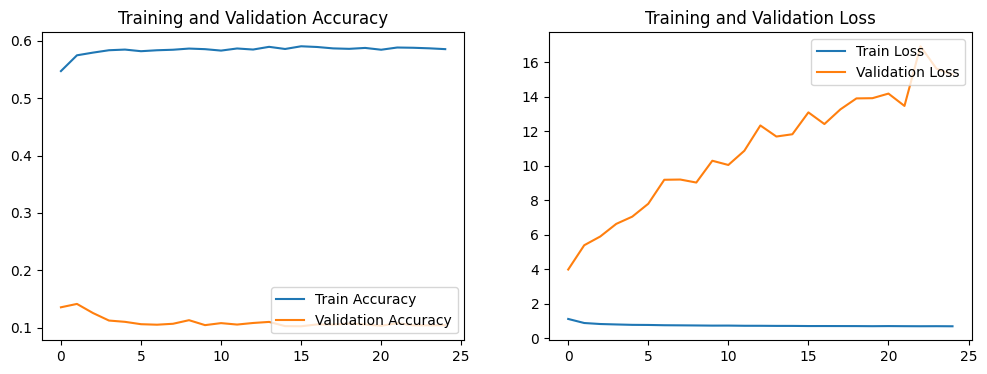

250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 693ms/step


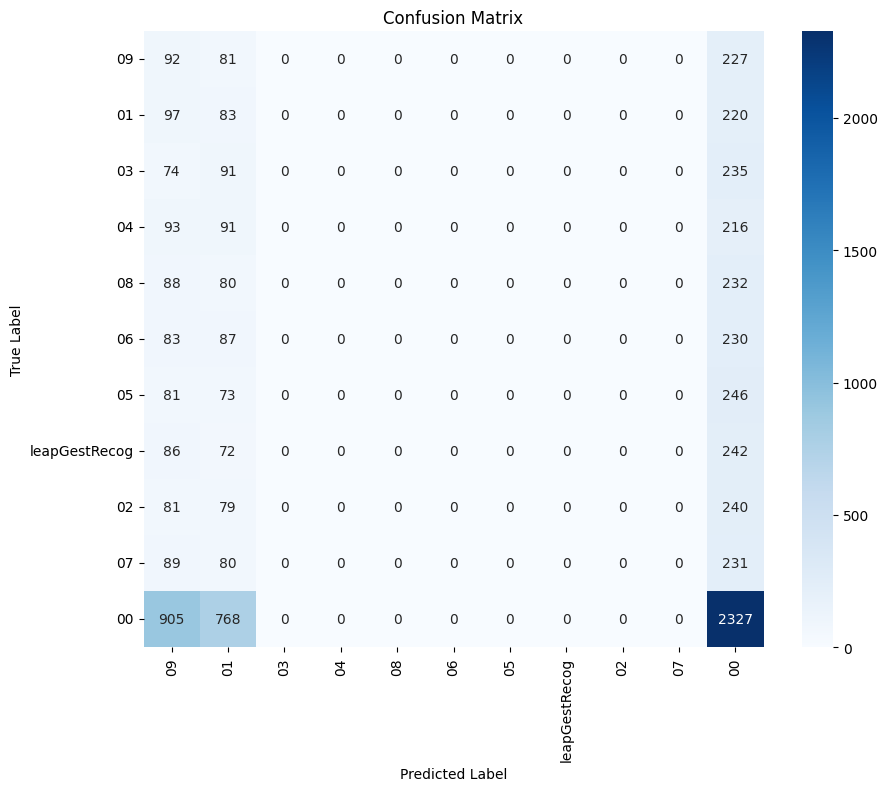

               precision    recall  f1-score   support

           09       0.05      0.23      0.08       400
           01       0.05      0.21      0.08       400
           03       0.00      0.00      0.00       400
           04       0.00      0.00      0.00       400
           08       0.00      0.00      0.00       400
           06       0.00      0.00      0.00       400
           05       0.00      0.00      0.00       400
leapGestRecog       0.00      0.00      0.00       400
           02       0.00      0.00      0.00       400
           07       0.00      0.00      0.00       400
           00       0.50      0.58      0.54      4000

     accuracy                           0.31      8000
    macro avg       0.06      0.09      0.06      8000
 weighted avg       0.26      0.31      0.28      8000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
# Import necessary libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate on the validation set
validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=gesture_classes, yticklabels=gesture_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=gesture_classes))


In [12]:
import tensorflow as tf

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('gesture_recognition_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpm_36hkg3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_319')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  133334042670912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334042671088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334043264272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334042671440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334042670208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334043267968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334043267440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334043271312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334043268672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334043269552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133334043